# Rasterize tree canopy

This notebook (re-)casts the tree canopy areas of each Census Tract as a raster. 

The outputs are binary tiffs for each Tract for 2010 and 2017 at 1-ft resolution with values for 'canopy', 'no canopy', and 'no data' (indicating area outside the tract boundary.


#### Reusable components:
- clip and combine vector geometries
- create new vector geometry to fill 'empty' area within a boundary
- recast vector geometry as xarray raster
- interatively open sections of a larger geodatabase (within a mask area), processs, save as raster

#### ToC:

1. install packages and read in data
2. test process and rasterize a single Census Tract
3. loop through all Census Tracts

[ here the tiffs go over to R to be processesd with FRAGSTATS ]

4. read in FRAC results


## install packages and read in data

In [ ]:
# Install gdal
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-3w0yyrv7
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-3w0yyrv7
  fatal: remote error:
    The unauthenticated git protocol on port 9418 is no longer supported.
  Please see https://github.blog/2021-09-01-improving-git-protocol-security-github/ for more information.
ERROR: Command errored out with exit status 128: git clone -q git

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 16.7 MB 344 kB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import numpy as np

In [ ]:
pip install geocube

  Using cached geocube-0.1.0.tar.gz (17 kB)
     |████████████████████████████████| 271 kB 4.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 47 kB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 103 kB 39.5 MB/s 
  Created wheel for geocube: filename=geocube-0.1.0-py3-none-any.whl size=21499 sha256=6197ccbd0e61f3fc4ca771f561e0983f4eb3e4e66f9de0e2f2e6ed4b224c78c4
  Stored in directory: /root/.cache/pip/wheels/86/c2/4c/2a0804a69bfb6e069eda5896eb995eb2f1aee234d25599ef0f
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=b3a69e5fd325424357e448b9114dd0c9c46df3a92b60939ab94fd578df725a2b
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built geocube rioxarray


In [ ]:
from geocube.api.core import make_geocube

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
pip install xarray

In [ ]:
import xarray as xr

## read in census tracts

In [ ]:
# downloaded from Census TIGER - all of NYS

ct = gpd.read_file('/content/drive/MyDrive/Advanced Spatial/project 1/tl_2010_36_tract10/tl_2010_36_tract10.shp')

In [ ]:
# filter to NYC (by counties)

ct = ct.loc[ct['COUNTYFP10'].isin(['005','047', '061', '081', '085'])]

In [ ]:
# to local projection (spec in feet)

ct.to_crs('EPSG:2263', inplace=True)

In [ ]:
ct = ct.rename(columns={'GEOID10':'GEOID'})

In [ ]:
ct = ct.set_index('GEOID')

## test rasterize one census tract

In [ ]:
# thank you !! https://www.linkedin.com/pulse/rasterize-polygons-geopandas-geocube-chonghua-yin

In [ ]:
i = '36061007000'

# set tract geometry for maks and clip
masker = ct.loc[i,'geometry']

# open canopy file intersecting (within) tract boundary
ct_canopy = gpd.read_file('/content/drive/MyDrive/Advanced Spatial/project 1/NYC_TreeCanopyChange_2010_2017.gdb',
                               mask=masker)
    
# clip canopy to tract boundary
ct_canopy = ct_canopy.clip(masker)

In [ ]:
# classify canopy areas for each year (2010 = no change + loss ; 2017 = no change + gain). Binary (1) as value for canopy present.

ct_canopy['cp_2010'] = ct_canopy['Class'].isin(['No Change','Loss']).astype(int)
ct_canopy['cp_2017'] = ct_canopy['Class'].isin(['No Change','Gain']).astype(int)

In [ ]:
# dissolve all geomotries where canopy is present into a single geometry

all_canopy_2010 = ct_canopy.loc[ct_canopy['cp_2010'].astype(bool)].unary_union
all_canopy_2017 = ct_canopy.loc[ct_canopy['cp_2017'].astype(bool)].unary_union

In [ ]:
# create new geometry for no-canopy area from difference 

no_canopy_2010 = ct.loc[[i]].difference(all_canopy_2010)
no_canopy_2017 = ct.loc[[i]].difference(all_canopy_2017)

In [ ]:
# create new geodataframes for each year with just geometries for canopy and no canopy areas

canopy_2010_shapes = gpd.GeoSeries([all_canopy_2010, no_canopy_2010[0]], crs='EPSG:2263')
canopy_2017_shapes = gpd.GeoSeries([all_canopy_2017, no_canopy_2017[0]], crs='EPSG:2263')

In [ ]:
canopy_2010 = gpd.GeoDataFrame(data={'canopy_2010':[1,0]}, geometry=canopy_2010_shapes)
canopy_2017 = gpd.GeoDataFrame(data={'canopy_2017':[1,0]}, geometry=canopy_2017_shapes)

In [ ]:
# create raster

raster_cp_2010 = make_geocube(     # make_geocube to make xarray raster
    vector_data = canopy_2010,
    measurements = ['canopy_2010'], # variable value
    resolution = (1,1), # speced in crs units (feet)
    fill = -999  # fill NaNs (outside of tract boundary)
)

In [ ]:
raster_cp_2017 = make_geocube(
    vector_data = canopy_2017,
    measurements = ['canopy_2017'],
    resolution = (1,1),
    fill = -999
)

In [ ]:
# save files

filename_2010 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2010.tiff'

raster_cp_2010.rio.to_raster(filename_2010)


filename_2017 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2017.tiff'

raster_cp_2017.rio.to_raster(filename_2017)

In [ ]:
# plot

fig = plt.figure(figsize=(15, 13))
ax = fig.add_subplot(1, 1, 1)


# use xarray to plot raster

da_grib = xr.where(raster_cp_2010['canopy_2010']<0, np.nan, raster_cp_2010['canopy_2010'])
da_grib.plot(ax=ax)

## test loop on list of census tracts

In [ ]:
import random

In [ ]:
random.seed(1)

In [ ]:
ct_sample = ct.sample(10)

In [ ]:
ct_list = ct_sample.index.to_list()

In [ ]:
ct_list

['36081048100',
 '36081079000',
 '36047048600',
 '36005006100',
 '36047003400',
 '36005030100',
 '36047049500',
 '36047017100',
 '36081118700',
 '36061007000']

In [ ]:
%%time



for i in ct_list:
    
    # set tract geomety for maks and clip
    geom = ct.loc[i,'geometry']

    # open canopy file intersecting (within) tract boundary
    ct_canopy = gpd.read_file('/content/drive/MyDrive/Advanced Spatial/project 1/NYC_TreeCanopyChange_2010_2017.gdb',
                               mask=geom)
    
    # clip canopy to tract boundary
    ct_canopy = ct_canopy.clip(geom)


    # compute 2010 and 2017 areas
    ct_canopy['cp_2010'] = ct_canopy['Class'].isin(['No Change','Loss']).astype(int)
    ct_canopy['cp_2017'] = ct_canopy['Class'].isin(['No Change','Gain']).astype(int)

    # merge canopy areas
    all_canopy_2010 = ct_canopy.loc[ct_canopy['cp_2010'].astype(bool)].unary_union
    all_canopy_2017 = ct_canopy.loc[ct_canopy['cp_2017'].astype(bool)].unary_union

    # compute non-canopy area
    no_canopy_2010 = ct.loc[[i]].difference(all_canopy_2010)
    no_canopy_2017 = ct.loc[[i]].difference(all_canopy_2017)

    # make geodataframes
    canopy_2010_shapes = gpd.GeoSeries([all_canopy_2010, no_canopy_2010[0]], crs='EPSG:2263')
    canopy_2017_shapes = gpd.GeoSeries([all_canopy_2017, no_canopy_2017[0]], crs='EPSG:2263')

    canopy_2010 = gpd.GeoDataFrame(data={'canopy_2010':[1,0]}, geometry=canopy_2010_shapes)
    canopy_2017 = gpd.GeoDataFrame(data={'canopy_2017':[1,0]}, geometry=canopy_2017_shapes)


    # rasterize
    raster_cp_2010 = make_geocube(
    vector_data = canopy_2010,
    measurements = ['canopy_2010'],
    resolution = (1,1),
    fill = -999)

    raster_cp_2017 = make_geocube(
    vector_data = canopy_2017,
    measurements = ['canopy_2017'],
    resolution = (1,1),
    fill = -999)

    # save tiffs
    filename_2010 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2010.tiff'
    raster_cp_2010.rio.to_raster(filename_2010)

    filename_2017 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2017.tiff'
    raster_cp_2017.rio.to_raster(filename_2017)


CPU times: user 29 s, sys: 9.15 s, total: 38.2 s
Wall time: 1min


## now _all_ the census tracts

In [ ]:
ct_list = ct.index.to_list()

In [ ]:
%%time

# keep track of successes and errors
cts_processed = []
errors = []

for i in ct_list:
  
  # set tract geomety for mask and clip
  masker = ct.loc[i,'geometry']

  # open canopy file intersecting (within) tract boundary
  ct_canopy = gpd.read_file('/content/drive/MyDrive/Advanced Spatial/project 1/NYC_TreeCanopyChange_2010_2017.gdb',
                               mask=masker)
    
  # clip canopy to tract boundary
  ct_canopy = ct_canopy.clip(masker)


  # compute 2010 and 2017 areas
  ct_canopy['cp_2010'] = ct_canopy['Class'].isin(['No Change','Loss']).astype(int)
  ct_canopy['cp_2017'] = ct_canopy['Class'].isin(['No Change','Gain']).astype(int)

  # merge canopy areas
  all_canopy_2010 = ct_canopy.loc[ct_canopy['cp_2010'].astype(bool)].unary_union
  all_canopy_2017 = ct_canopy.loc[ct_canopy['cp_2017'].astype(bool)].unary_union

  # compute non-canopy area
   
  # to catch errors where there is no canopy so the difference fails
  try:
    no_canopy_2010 = ct.loc[[i]].difference(all_canopy_2010)
    no_canopy_2017 = ct.loc[[i]].difference(all_canopy_2017)

  except TypeError:
    errors.append(i)
    continue

  # make geodataframes
  canopy_2010_shapes = gpd.GeoSeries([all_canopy_2010, no_canopy_2010[0]], crs='EPSG:2263')
  canopy_2017_shapes = gpd.GeoSeries([all_canopy_2017, no_canopy_2017[0]], crs='EPSG:2263')

  canopy_2010 = gpd.GeoDataFrame(data={'canopy_2010':[1,0]}, geometry=canopy_2010_shapes)
  canopy_2017 = gpd.GeoDataFrame(data={'canopy_2017':[1,0]}, geometry=canopy_2017_shapes)


  # rasterize
  raster_cp_2010 = make_geocube(
  vector_data = canopy_2010,
  measurements = ['canopy_2010'],
  resolution = (1,1),
  fill = -999)

  raster_cp_2017 = make_geocube(
  vector_data = canopy_2017,
  measurements = ['canopy_2017'],
  resolution = (1,1),
  fill = -999)

  # save tiffs
  filename_2010 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2010.tiff'
  raster_cp_2010.rio.to_raster(filename_2010)

  filename_2017 = f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2017.tiff'
  raster_cp_2017.rio.to_raster(filename_2017)

  cts_processed.append(i)


In [ ]:
errors

In [ ]:
# when completed, check which files were (and weren't created)

from os.path import exists

In [ ]:
cts_processed = []

for i in ct_list:
  cts_processed.append(
      exists(f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2010.tiff') and exists(f'/content/drive/MyDrive/Advanced Spatial/project 1/rasters/{i}_2017.tiff')
  )

In [ ]:
ct['tiff processed'] = cts_processed

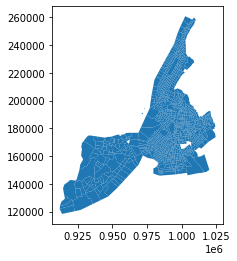

In [ ]:
ct[ct['tiff processed']].plot() 

# hm just a problem with the bronx? 

In [ ]:
ct[ct['COUNTYFP10'] == '061']['tiff processed'].all()

# all on Manhattan is there - -I'll use that

True

In [ ]:
ct[ct['COUNTYFP10'] == '061'].index.to_list()

... here I proocess the PARFRAC in R ... 
...

## read in FRAC results

In [ ]:
frac = pd.read_csv('/content/drive/MyDrive/Advanced Spatial/project 1/frac_result.csv', index_col=0)

In [ ]:
frac = frac.rename(columns={'ct_list':'GEOID'})

In [ ]:
frac['GEOID'] = frac['GEOID'].astype(str)

In [ ]:
frac = frac.set_index('GEOID')

In [ ]:
frac = gpd.GeoDataFrame(data = frac, geometry = ct['geometry'])

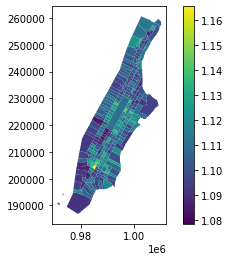

In [ ]:
frac.plot(column = 'canopy_2010_results', legend=True)

In [ ]:
frac.isna().sum()

no_canopy_2010_results    0
canopy_2010_results       0
no_canopy_2017_results    0
canopy_2017_results       0
geometry                  0
dtype: int64

In [ ]:
len(ct[ct['COUNTYFP10'] == '061'].index.to_list())

288